In [2]:


import numpy as np 
import pandas as pd 
import os


In [3]:
import librosa

In [4]:
librosa.__version__

'0.10.1'

In [2]:

import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display as ipd
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import tensorflow
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras 
import keras_tuner
from skimage.transform import resize

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

2025-01-19 17:26:56.706829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 17:26:56.706954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 17:26:56.863395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
random_sample = '/kaggle/input/urbansound8k/fold7/157940-9-0-4.wav'
metadata = pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
audio_dataset_path = '/kaggle/input/urbansound8k'

In [4]:
import os
import random


folder_path = "/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs"

# Get a list of all files in the folder
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]


num_samples = 100
files = []

if len(all_files) < num_samples:
    print("Not enough files to sample.")
else:
  
    for i in range(num_samples):
        random_file = random.choice(all_files)
       
        files.append("/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/"+random_file)


In [5]:
import random

v_list = metadata.loc[(metadata['class'] == 'street_music') & (metadata['fold'] == 3), 'slice_file_name'].tolist()
n_list = metadata.loc[((metadata['class'] == 'drilling') | (metadata['class'] == 'jackhammer'))& (metadata['fold'] == 4), 'slice_file_name'].tolist()
v_list = [f'/kaggle/input/urbansound8k/fold3/{f}' for f in v_list]
n_list = [f'/kaggle/input/urbansound8k/fold4/{f}' for f in n_list]

In [6]:
import librosa
import numpy as np

def feature_extraction(file):
    
    audio, sample_rate = librosa.load(file)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=64)
    zc = librosa.feature.zero_crossing_rate(y=audio)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    zc_scaled_features = np.mean(zc.T, axis=0)
    combined_features = np.concatenate((mfccs_scaled_features, zc_scaled_features))   
    return combined_features

extracted_features = []

In [7]:
from glob import glob# Iterating through each row


c=0
for file in glob('/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/*.wav'):
    data = feature_extraction(file)
    extracted_features.append([data, 'speech'])
    c +=1
    if c>500:
        break

for index_num, row in tqdm(metadata.iterrows()):
    # Constructing file path
    if row['class'] in {'street_music', 'jackhammer', 'drilling'}:
        audioFile = os.path.join(audio_dataset_path, 'fold' + str(row['fold']), row['slice_file_name'])
        final_class_labels = row["class"]
        data = feature_extraction(audioFile)
        extracted_features.append([data,final_class_labels])

    

8732it [02:57, 49.07it/s] 


In [8]:
def visualize(path):
    data, sample_rate = librosa.load(path)
    plt.figure(figsize=(19, 10))

    # waveform 
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(data, sr=sample_rate)
    plt.title("Waveform of the Audio")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")

    mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=64)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(mfccs_features, x_axis='time', sr=sample_rate)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC (Mel-frequency cepstral coefficients)')

    
    plt.xlabel('Time (seconds)')
    plt.ylabel('64   MFCC Coefficients')

    #  plot
   
    plt.show()
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    plt.bar(range(len(mfccs_scaled_features)), mfccs_scaled_features)
    plt.xlabel('MFCC Coefficients')
    plt.ylabel('Mean Value')
    plt.title('Scaled MFCC Features (Mean)')
    plt.show()
  

   


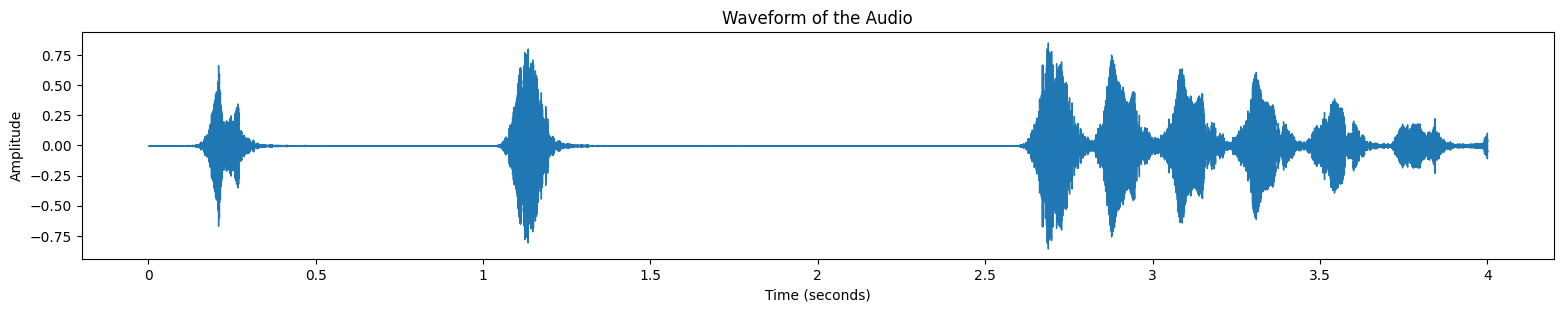

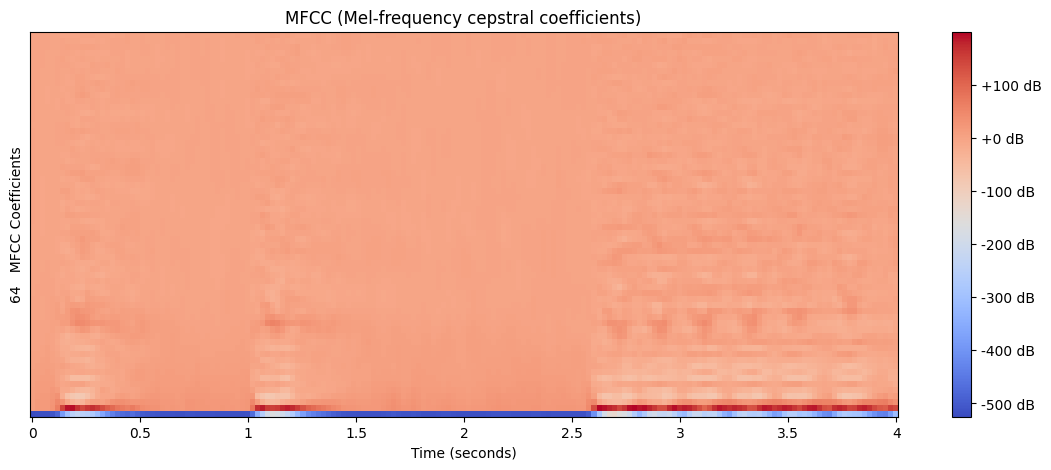

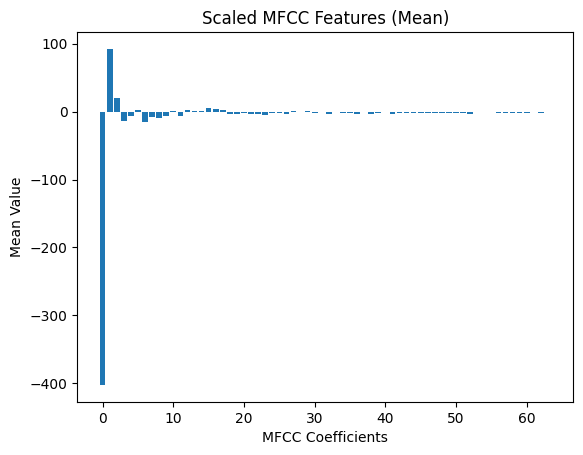

In [9]:
visualize("/kaggle/input/urbansound8k/fold1/101415-3-0-2.wav");

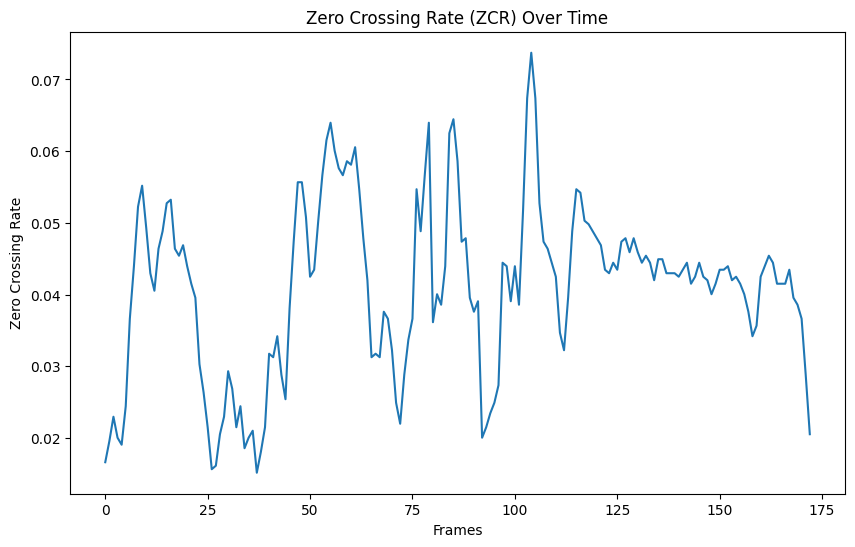

In [10]:

  data, sample_rate = librosa.load("/kaggle/input/urbansound8k/fold1/101415-3-0-2.wav")

zero_crossings = librosa.feature.zero_crossing_rate(y=data)


plt.figure(figsize=(10, 6))
plt.plot(zero_crossings.T)  
plt.title('Zero Crossing Rate (ZCR) Over Time')
plt.xlabel('Frames')
plt.ylabel('Zero Crossing Rate')
plt.show()

In [11]:
c = 0
for root, dirs, files in os.walk('/kaggle/input/speech-activity-detection-datasets/Data/Audio'):
        for file in files:
            if file.endswith(".wav"):
                data = feature_extraction(os.path.join(root, file))
               # Filter for .wav files
                extracted_features.append([data, 'speech'])               
                c+=1

    

In [12]:
extracted_features_df = pd.DataFrame(extracted_features,columns =['features','class'] )
extracted_features_df.head(10)


extracted_features_df.loc[extracted_features_df['class'].isin(['drilling', 'jackhammer']), 'class'] = 'noise'
noise_indices = extracted_features_df[extracted_features_df['class'] == 'noise'].index

extracted_features_df = extracted_features_df.drop(noise_indices[:1000])

extracted_features_df['class'].value_counts()

class
speech          1220
street_music    1000
noise           1000
Name: count, dtype: int64

In [13]:

X = np.array(extracted_features_df['features'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state=42)

In [16]:
def build_model(hp):
    model = keras.Sequential()
    num_of_layer = hp.Int('num_of_layer', min_value=1, max_value=3, step=1)
    model.add(keras.layers.InputLayer(input_shape=(65,)))
    for i in range(num_of_layer):
        model.add(keras.layers.Dense(
            units=hp.Int(f'unit_{i}_layer', min_value=16, max_value=32, step=4),
            activation='relu'
        ))
        model.add(keras.layers.Dropout(
            rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        ))
    model.add(keras.layers.Dense(3, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [17]:
tuner1 = keras_tuner.RandomSearch(hypermodel=build_model, objective='val_accuracy', max_trials=5, max_retries_per_trial=3,
                                directory = '/kaggle/working/',
                                 )

In [18]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tensorflow.keras.callbacks.TensorBoard(log_dir="./logs",histogram_freq=1,  # Frequency for histogram computation
    write_graph=True, 
    write_images=True),
]

In [19]:
tuner1.search(X_train, y_train , epochs = 20, validation_data = (X_test, y_test), callbacks = callbacks)

Trial 5 Complete [00h 00m 09s]
val_accuracy: 0.9798136353492737

Best val_accuracy So Far: 0.9798136353492737
Total elapsed time: 00h 01m 03s


In [20]:
best_param = tuner1.get_best_hyperparameters(num_trials=1)[0]


In [21]:
model1 = tuner1.hypermodel.build(best_param)

In [22]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,211 (8.64 KB)

 Trainable params: 2,211 (8.64 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model1.fit(X_train, y_train ,epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6726 - loss: 4.4675 - val_accuracy: 0.9006 - val_loss: 0.2534
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8781 - loss: 0.3238 - val_accuracy: 0.8960 - val_loss: 0.2095
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9008 - loss: 0.2267 - val_accuracy: 0.9286 - val_loss: 0.1576
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9368 - loss: 0.1571 - val_accuracy: 0.9394 - val_loss: 0.1234
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9513 - loss: 0.1287 - val_accuracy: 0.9534 - val_loss: 0.0970
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9519 - loss: 0.1128 - val_accuracy: 0.9658 - val_loss: 0.0742
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9636 - loss: 0.1071 - val_accuracy: 0.9658 - val_loss: 0.0838
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9486 - loss: 0.1165 - val_accuracy: 0.9720 - val_loss

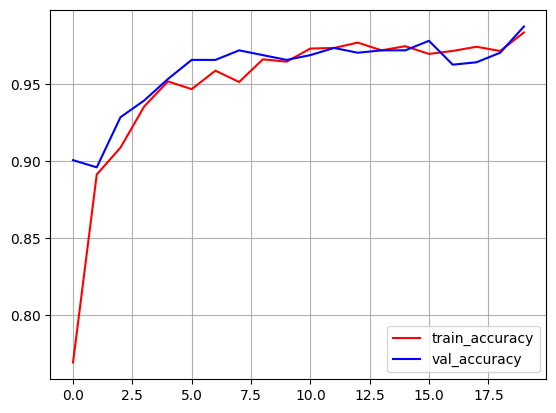

In [24]:
plt.plot(history.history['accuracy'], color = 'red',label = 'train_accuracy' )
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
plt.legend()
plt.grid()
plt.plot()
plt.show()

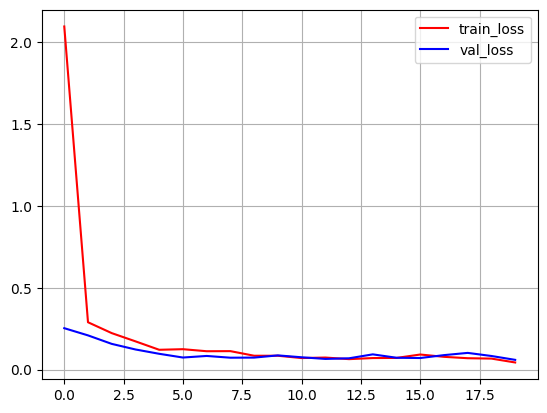

In [25]:
plt.plot(history.history['loss'], color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'val_loss')
plt.legend()
plt.grid()
plt.plot()
plt.show()

In [26]:
import librosa
import numpy as np
import scipy.stats as stats
from IPython.display import Audio

# Function to add Rayleigh noise
def add_rayleigh_noise(audio, snr_db):
    noise_power = np.mean(audio**2) / (10**(snr_db / 10))  # Signal power divided by SNR
    noise = np.sqrt(noise_power) * np.random.rayleigh(scale=5, size=audio.shape)
    noisy_audio = audio + noise
    return noisy_audio

# Load audio file
random_sample = '/kaggle/input/speech-activity-detection-datasets/Data/Audio/Female/PTDB-TUG/mic_F01_sa2.wav'
audio, sample_rate = librosa.load(random_sample) 

# Apply Rayleigh noise with a desired SNR (Signal to Noise Ratio)
snr_db = 0.0000000000000000000000000000000000000000000000000000000000000000000000000001  # Adjust SNR as required
noisy_audio_rayleigh = add_rayleigh_noise(audio, snr_db)

# Listen to the noisy audio
Audio(noisy_audio_rayleigh, rate=sample_rate)


In [27]:
# Function to add Rayleigh noise
def add_rayleigh_noise(audio, snr_db):
    noise_power = np.mean(audio**2) / (10**(snr_db / 10))  # Signal power divided by SNR
    noise = np.sqrt(noise_power) * np.random.rayleigh(scale=1, size=audio.shape)
    noisy_audio = audio + noise
    return noisy_audio

# Function to add Nakagami noise
def add_nakagami_noise(audio, snr_db, m=1.5):
    noise_power = np.mean(audio**2) / (10**(snr_db / 10))  # Signal power divided by SNR
    noise = np.sqrt(noise_power) * stats.nakagami.rvs(m, size=audio.shape)
    noisy_audio = audio + noise
    return noisy_audio

# Feature extraction function
def feature_extraction(audio, sample_rate):
    # Extract MFCC features
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=64)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    # Extract Zero Crossing Rate (ZCR)
    zc = librosa.feature.zero_crossing_rate(y=audio)
    zc_scaled_features = np.mean(zc.T, axis=0)

    # Combine features
    combined_features = np.concatenate((mfccs_scaled_features, zc_scaled_features))
    return combined_features

# Load audio file
random_sample = '/kaggle/input/testdata/Record (online-voice-recorder.com).wav'
audio, sample_rate = librosa.load(random_sample)

# Apply Rayleigh noise with a desired SNR (Signal to Noise Ratio)
snr_db = 10  # Adjust SNR as required
noisy_audio_rayleigh = add_rayleigh_noise(audio, snr_db)

# Extract features from noisy audio
combined_features = feature_extraction(noisy_audio_rayleigh, sample_rate)

# Reshape features for prediction
combined_features = combined_features.reshape(1, -1)

# Predict with the model
x_predict = model1.predict(combined_features)
predicted_label = np.argmax(x_predict, axis=1)



# Decode and print the prediction
prediction_class = labelencoder.inverse_transform(predicted_label)
print(x_predict)
print(prediction_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
[[2.4759448e-11 1.0000000e+00 2.2171243e-08]]
['speech']


In [28]:
#for testing on some random data from a list
for f in n_list:   
    random_sample = f
    audio, sample_rate = librosa.load(random_sample) 
    
    mfccs_scaled_features = feature_extraction(noisy_audio_rayleigh, sample_rate)
    
    #Reshape MFCC feature to 2-D array
    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    
    
    
    #predicted_label=model.predict_classes(mfccs_scaled_features)
    x_predict=model1.predict(mfccs_scaled_features) 
    predicted_label=np.argmax(x_predict,axis=1)
    
    prediction_class = labelencoder.inverse_transform(predicted_label) 
    print(x_predict)
    print(prediction_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[2.4759448e-11 1.0000000e+00 2.2171243e-08]]
['speech']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[2.4759448e-11 1.0000000e+00 2.2171243e-08]]
['speech']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[2.4759448e-11 1.0000000e+00 2.2171243e-08]]
['speech']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[2.4759448e-11 1.0000000e+00 2.2171243e-08]]
['speech']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[2.4759448e-11 1.0000000e+00 2.2171243e-08]]
['speech']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[2.4759448e-11 1.0000000e+00 2.2171243e-08]]
['speech']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[2.4759448e-11 1.0000000e+00 2.2171243e-08]]
['speech']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[2.4759448e-11 1.0000000e+00 2.2171243e-08]]
['speech']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[2.4759448e-11 1.0000000e+00 2.2171243e-08]]
['speech']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[2.4759448e-11 1.0000000e+00 2.2171243e-08]]
['speech']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[2.4759448e

In [4]:
from tensorflow.keras.models import load_model, save_model

load_model(model1, '/kaggle/input/modell/final_model.h5')

NameError: name 'model1' is not defined

AttributeError: Can't pickle local object 'Layer._initializer_tracker.<locals>.<lambda>'

In [5]:
from tensorflow.keras.models import load_model

# Load the model from the specified path
model = load_model('/kaggle/input/modell/final_model.h5')

# Now you can use the model, e.g., print the summary
print(model.summary())


with open("final_model.pkl", "wb") as pkl_file:
    pickle.dump(model, pkl_file)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213 (8.65 KB)

 Trainable params: 2,211 (8.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [6]:
import pickle

# Export the trained model
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)


AttributeError: Can't pickle local object 'Layer._initializer_tracker.<locals>.<lambda>'

In [35]:
import  sklearn

In [36]:
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)

1.26.4
2.2.0
1.2.2
